# Time Travel

## Review

We disussed motivations for human-in-the-loop:

- `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action.
- `Debugging` - We can rewind the graph to reproduce or avoid issues.
- `Editing` - You can also modify the state.

We showed how breakpoints can stop the graph at specific nodes.

Then we showed how to proceed with human approval or directly edit the graph state with human feedback.

## Goals

Now, let's show how LangGraph supports debugging by viewing, re-playing, and even forking from past states.

We call this `time travel`.

Let's build our agent.

## Dependencies

In [1]:
from langchain_ollama import ChatOllama
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import display, Image
from pprint import pprint

In [2]:
llm = ChatOllama(
    model="llama3.1-tool",
    base_url="http://localhost:11434",
    temperature=0.8,
    max_tokens=1000
)

In [3]:
# Defining tools
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a*b

def add(a: int, b:  int) -> int:
    """Adds a and b.
    
    Args:
        a: first int
        b: second int
    """
    return a+b

def divide(a:  int, b: int) -> float:
    """Divide a and b.
    
    Args:
        a: first int
        b: second int
    """
    return a/b

In [4]:
tools = [multiply, add, divide]
llm_with_tools = llm.bind_tools(tools)

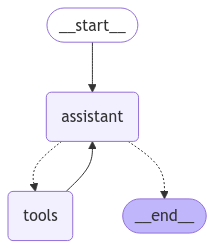

In [5]:
# System Message
system_message = SystemMessage(content="You are a helpful AI assistant tasked to perform arithmetic operations on a set of inputs.")

# Node
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([system_message] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define Nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Add edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")

# Compile
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

# Show
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
# Thread
thread = {"configurable": {"thread_id":"1"}}

In [7]:
# Input
initial_input = {"messages": "Multiply 2 and 3."}

# Run the Graph
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3.
================================== Ai Message ==================================
Tool Calls:
  multiply (4a64a1fc-a3d8-4bcd-984d-92ddec7ae8b5)
 Call ID: 4a64a1fc-a3d8-4bcd-984d-92ddec7ae8b5
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


## Browsing History

We can use `get_state` to look at the **current** state of our graph, given the `thread_id`!

In [8]:
state = graph.get_state({"configurable":{"thread_id":"1"}})
pprint(state)

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3.', additional_kwargs={}, response_metadata={}, id='804d2fb4-57b0-45a1-8461-55477950ba2a'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.1-tool', 'created_at': '2025-01-15T12:07:57.579064Z', 'done': True, 'done_reason': 'stop', 'total_duration': 7004872200, 'load_duration': 5656895800, 'prompt_eval_count': 340, 'prompt_eval_duration': 426000000, 'eval_count': 22, 'eval_duration': 446000000, 'message': {'role': 'assistant', 'content': '', 'images': None, 'tool_calls': None}}, id='run-a9b17582-427d-4d81-9a29-4af526fff9aa-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': '4a64a1fc-a3d8-4bcd-984d-92ddec7ae8b5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 340, 'output_tokens': 22, 'total_tokens': 362}), ToolMessage(content='6', name='multiply', id='5735703e-2dc3-4f3b-b5bc-1737a6845d7e', tool_call_id='4a64a1fc-a3d8-4bcd-984d-92ddec7ae8b5'), AIMessage(conte

We can also browse the state history of our agent.

`get_state_history` let us get the state at all prior steps.

In [9]:
all_states = [s for s in graph.get_state_history(thread)]

In [10]:
len(all_states)

5

Let's print the history. As we can see the most recent message is the first one in the list of `StateSnapshot` (A wrapper for a checkpoint).

And each StateSnapshot have a checkpoint id, the number of messages accumulated in each super-step, and the next node to be executed.

In [11]:
for state in all_states:
    print("ID: ", state.config["configurable"]["checkpoint_id"])
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)

ID:  1efd3395-bd4a-61b3-8003-320e40fd9fb3
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
ID:  1efd3395-ba47-68a2-8002-f27e2bb0320b
Num Messages:  3 Next:  ('assistant',)
--------------------------------------------------------------------------------
ID:  1efd3395-ba3e-66a6-8001-01605bb15940
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
ID:  1efd3395-58ed-67be-8000-af85423b55e4
Num Messages:  1 Next:  ('assistant',)
--------------------------------------------------------------------------------
ID:  1efd3395-58e6-6253-bfff-91cdf8156ae4
Num Messages:  0 Next:  ('__start__',)
--------------------------------------------------------------------------------


The first element of this list is the current state, just as we got from `get_state`.

In [12]:
current = all_states[0]
print("Num Messages: ", len(current.values["messages"]), "Next: ", current.next)
print("-" * 80)
for m in current.values["messages"]:
    print(m.content)

Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Multiply 2 and 3.

6
The result of multiplying 2 and 3 is 6.


Everything above can be visualized here:

<center><img src="../../../assets/get_state.jpg" width=900 alt="get_state"></img></center>

## Replaying

We can re-run our agent from any of the prior steps.

<center><img src="../../../assets/re_playing.jpg" width=900 alt="replaying"></img></center>

Previously we saw that by passing an input as `None` to stream with the `thread_id`, the graph pick up the execution from the current state.

But, what if we set a `checkpoint_id` as well? 

Then we will re-play the graph from this checkpoint till the current checkpoint state.

This means that, the graph won't execute from `__start__` node till the end node, this is a re-execution.

Instead, the graph will execute the subsequential nodes starting from the node whose `checkpoint_id` was select to start from.

Then it will add these new subsequential checkpoints to the checkpoint history.

So, to catch up:

If we have a Graph with nodes 1, 2, 3, and 4 and the path of execution is `1 -> 2 -> 3 -> 4`, then:

- Replay: By selecting checkpoint from node `2`, the graph will execute `2 -> 3 -> 4` and the checkpoint history will be `1, 2, 3, 4, 2, 3, 4`
- Rexecute: it will execute the graph from start, so `1 -> 2 -> 3 -> 4`, hence the checkpoint history will be: `1, 2, 3, 4, 1, 2, 3, 4`

Let's look back at the step that received human input!

In [13]:
to_replay = all_states[-2]

Look at the state

In [14]:
to_replay.values

{'messages': [HumanMessage(content='Multiply 2 and 3.', additional_kwargs={}, response_metadata={}, id='804d2fb4-57b0-45a1-8461-55477950ba2a')]}

We can see the next node to call.

In [15]:
to_replay.next

('assistant',)

We also get the config, which tell us the `checkpoint_id` as well as the `thread_id`.

In [16]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd3395-58ed-67be-8000-af85423b55e4'}}

To replay from here, we simply pass the config back to the agent!

The graph knows that this checkpoint has already been executed.

It just re-plays from this checkpoint!

In [17]:
for event in graph.stream(None, config=to_replay.config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3.
================================== Ai Message ==================================
Tool Calls:
  multiply (be008db3-9412-4009-82f4-a0b65f53e40c)
 Call ID: be008db3-9412-4009-82f4-a0b65f53e40c
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


Now we can see the history and as we selected the checkpoint from the node `assistant`, we will see that the appended checkpoints are `assistant`, `tools` and `assistant` again, meaning that only nodes starting from the checkpoint were executed and their produced checkpoints were added to the historyof checkpoints.

In [18]:
for state in graph.get_state_history(thread):
    print("ID: ", state.config["configurable"]["checkpoint_id"])
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)

ID:  1efd33aa-ee18-601c-8003-5aee3f322353
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
ID:  1efd33aa-eb08-64ac-8002-12a8e3d86859
Num Messages:  3 Next:  ('assistant',)
--------------------------------------------------------------------------------
ID:  1efd33aa-eb03-6686-8001-bf7599a5e5af
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
ID:  1efd3395-bd4a-61b3-8003-320e40fd9fb3
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
ID:  1efd3395-ba47-68a2-8002-f27e2bb0320b
Num Messages:  3 Next:  ('assistant',)
--------------------------------------------------------------------------------
ID:  1efd3395-ba3e-66a6-8001-01605bb15940
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
ID:  1efd3395-58ed-67be-8000-af85423b55e4
Num Messages:  1 N

## Forking

What if we want to run from that same step, but with a different input! This is forking.

<center><img src="../../../assets/forking.jpg" width=900 alt="forking"></img></center>

In this case you update a state at a certain checkpoint by passing a new `state`, given the `checkpoint_id` and `thread_id` of this state.

When you do that, you fork your graph, meaning that you create a new checkpoint as previously saw in replay, but now the graph will reexecutewhen you stream/invoke the graph.

Because the graph knows that the state changed at that `checkpoint_id`, so it needs to be re-executed to get the next states.

In [19]:
to_fork = all_states[-2]
to_fork.values["messages"]

[HumanMessage(content='Multiply 2 and 3.', additional_kwargs={}, response_metadata={}, id='804d2fb4-57b0-45a1-8461-55477950ba2a')]

Again, we have the config.

In [20]:
to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd3395-58ed-67be-8000-af85423b55e4'}}

Let's modify the state at this checkpoint.

We can just run `update_state` with the `checkpoint_id` supplied.

Remember how our reducer on `messages` works:

- It will append, unless we supply a message ID.
- We supply the message ID to overwritte the message, rather than appending to state!

So, to overwritte the message, we just supply the message ID, which we have with `to_fork.values["messages"].id`

In [21]:
fork_config = graph.update_state(to_fork.config, {"messages":[HumanMessage(content="Multiply 5 and 3.", id=to_fork.values["messages"][0].id)]})

In [22]:
fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd33c0-c198-6ec3-8001-0dff22e97c8e'}}

We now see a new checkpoint added to a state history (length 6 now, versus 5 above)

In [23]:
all_states = [s for s in graph.get_state_history(thread)]
len(all_states)

9

In [38]:
for state in all_states:
    print("ID: ", state.config["configurable"]["checkpoint_id"])
    #print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    if len(state.values["messages"]) > 0:
        print("Message: ", state.values["messages"][-1].content, "Id: ", state.values["messages"][-1].id)
    print("-" * 80)

ID:  1efd33c0-c198-6ec3-8001-0dff22e97c8e
Message:  Multiply 5 and 3. Id:  804d2fb4-57b0-45a1-8461-55477950ba2a
--------------------------------------------------------------------------------
ID:  1efd33aa-ee18-601c-8003-5aee3f322353
Message:  The result of multiplying 2 and 3 is 6. Id:  run-cfebe66d-d07e-4c3c-8b7c-ce2c9761f899-0
--------------------------------------------------------------------------------
ID:  1efd33aa-eb08-64ac-8002-12a8e3d86859
Message:  6 Id:  10f665a1-7997-475f-9759-276820cfbcb8
--------------------------------------------------------------------------------
ID:  1efd33aa-eb03-6686-8001-bf7599a5e5af
Message:   Id:  run-883d7c87-c68c-4f9e-9703-139bcb772fe0-0
--------------------------------------------------------------------------------
ID:  1efd3395-bd4a-61b3-8003-320e40fd9fb3
Message:  The result of multiplying 2 and 3 is 6. Id:  run-47c6c37d-480c-4d73-98f4-c0a55c6fe0a0-0
--------------------------------------------------------------------------------
ID:  1

In [33]:
new_state = all_states[0]
pprint(new_state)

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3.', additional_kwargs={}, response_metadata={}, id='804d2fb4-57b0-45a1-8461-55477950ba2a')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd33c0-c198-6ec3-8001-0dff22e97c8e'}}, metadata={'source': 'update', 'writes': {'__start__': {'messages': [HumanMessage(content='Multiply 5 and 3.', additional_kwargs={}, response_metadata={}, id='804d2fb4-57b0-45a1-8461-55477950ba2a')]}}, 'thread_id': '1', 'step': 1, 'parents': {}, 'checkpoint_ns': '', 'checkpoint_id': '1efd3395-58ed-67be-8000-af85423b55e4'}, created_at='2025-01-15T12:27:12.627475+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd3395-58ed-67be-8000-af85423b55e4'}}, tasks=(PregelTask(id='2179bf31-bd2c-8197-9ac1-ea5c6e2f2972', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),))


This creates a new, forked checkpoint.

But, the metadata -e.g., where to go next - is preserved!

We can see the current state of our agent has been updated with our fork.

In [40]:
new_state.values["messages"][0].content

'Multiply 5 and 3.'

In [42]:
pprint(graph.get_state(thread))

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3.', additional_kwargs={}, response_metadata={}, id='804d2fb4-57b0-45a1-8461-55477950ba2a')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd33c0-c198-6ec3-8001-0dff22e97c8e'}}, metadata={'source': 'update', 'writes': {'__start__': {'messages': [HumanMessage(content='Multiply 5 and 3.', additional_kwargs={}, response_metadata={}, id='804d2fb4-57b0-45a1-8461-55477950ba2a')]}}, 'thread_id': '1', 'step': 1, 'parents': {}, 'checkpoint_ns': '', 'checkpoint_id': '1efd3395-58ed-67be-8000-af85423b55e4'}, created_at='2025-01-15T12:27:12.627475+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd3395-58ed-67be-8000-af85423b55e4'}}, tasks=(PregelTask(id='2179bf31-bd2c-8197-9ac1-ea5c6e2f2972', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),))


Now, when we stream, the graph knows this checkpoint has never been executed.

So, the graph runs, rather than simply re-playing.

In [44]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 5 and 3.
================================== Ai Message ==================================
Tool Calls:
  multiply (01894159-c5d3-423b-b8d5-5afe778bdcbe)
 Call ID: 01894159-c5d3-423b-b8d5-5afe778bdcbe
  Args:
    a: 5
    b: 3
================================= Tool Message =================================
Name: multiply

15
================================== Ai Message ==================================

The result of multiplying 5 and 3 is 15.


In [45]:
pprint(graph.get_state(thread))

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3.', additional_kwargs={}, response_metadata={}, id='804d2fb4-57b0-45a1-8461-55477950ba2a'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.1-tool', 'created_at': '2025-01-15T12:45:58.8401143Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3582913500, 'load_duration': 2375998200, 'prompt_eval_count': 340, 'prompt_eval_duration': 250000000, 'eval_count': 22, 'eval_duration': 436000000, 'message': {'role': 'assistant', 'content': '', 'images': None, 'tool_calls': None}}, id='run-9be0be99-d829-4201-82bc-331f990a1466-0', tool_calls=[{'name': 'multiply', 'args': {'a': 5, 'b': 3}, 'id': '01894159-c5d3-423b-b8d5-5afe778bdcbe', 'type': 'tool_call'}], usage_metadata={'input_tokens': 340, 'output_tokens': 22, 'total_tokens': 362}), ToolMessage(content='15', name='multiply', id='b62803ac-86bc-4dd3-9de2-7d90eb0064d3', tool_call_id='01894159-c5d3-423b-b8d5-5afe778bdcbe'), AIMessage(con

In [47]:
for state in graph.get_state_history(thread):
    print("ID: ", state.config["configurable"]["checkpoint_id"])
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)

ID:  1efd33ea-b907-6926-8004-dfcbeabb3e2c
Num Messages:  4 Next:  ()
ID:  1efd33ea-b60b-6f7b-8003-5e59c0407e6c
Num Messages:  3 Next:  ('assistant',)
ID:  1efd33ea-b604-6b88-8002-d17d7ef17b14
Num Messages:  2 Next:  ('tools',)
ID:  1efd33c0-c198-6ec3-8001-0dff22e97c8e
Num Messages:  1 Next:  ('assistant',)
ID:  1efd33aa-ee18-601c-8003-5aee3f322353
Num Messages:  4 Next:  ()
ID:  1efd33aa-eb08-64ac-8002-12a8e3d86859
Num Messages:  3 Next:  ('assistant',)
ID:  1efd33aa-eb03-6686-8001-bf7599a5e5af
Num Messages:  2 Next:  ('tools',)
ID:  1efd3395-bd4a-61b3-8003-320e40fd9fb3
Num Messages:  4 Next:  ()
ID:  1efd3395-ba47-68a2-8002-f27e2bb0320b
Num Messages:  3 Next:  ('assistant',)
ID:  1efd3395-ba3e-66a6-8001-01605bb15940
Num Messages:  2 Next:  ('tools',)
ID:  1efd3395-58ed-67be-8000-af85423b55e4
Num Messages:  1 Next:  ('assistant',)
ID:  1efd3395-58e6-6253-bfff-91cdf8156ae4
Num Messages:  0 Next:  ('__start__',)


## Time Travel with API

Let's get the URL for the local deployment from Studio

To get it let's run `langgraph dev`.

In [48]:
from langgraph_sdk import get_client
client = get_client(url="http://localhost:2024")
assistant_id = "react"

## Re-playing

Let's run our agent streaming `updates` to the state of the graph after each node is called.

In [49]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3.")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"], assistant_id, input=initial_input,stream_mode="updates"
):
    if chunk.data:
        assistant_node = chunk.data.get("assistant",{}).get("messages",[])
        tool_node = chunk.data.get("tools",{}).get("messages",[])
        if assistant_node:
            print("-"*20 + " Assistant Node " + "-"*20)
            print(assistant_node[-1])
        elif tool_node:
            print("-"*20 + " Tool Node " + "-"*20)
            print(tool_node[-1])

-------------------- Assistant Node --------------------
{'content': '', 'additional_kwargs': {}, 'response_metadata': {'model': 'llama3.1-tool', 'created_at': '2025-01-15T12:56:02.332204Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3395942700, 'load_duration': 1849813300, 'prompt_eval_count': 376, 'prompt_eval_duration': 370000000, 'eval_count': 22, 'eval_duration': 479000000, 'message': {'role': 'assistant', 'content': '', 'images': None, 'tool_calls': None}}, 'type': 'ai', 'name': None, 'id': 'run-e861bdb5-8ddb-4be1-a687-c3a88a3e5740-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'ae534cef-9ce8-4495-9e17-90661207af20', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 376, 'output_tokens': 22, 'total_tokens': 398}}
-------------------- Tool Node --------------------
{'content': '6', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': '627905a7-038f-4f46-a

Now let's simply look at `replaying` from a specified checkpoint.

We need to pass the `checkpoint_id`.

In [50]:
states = await client.threads.get_history(thread['thread_id'])

In [52]:
for state in states:
    print("ID: ", state["checkpoint"]["checkpoint_id"])
    print("Num Messages: ", len(state["values"]["messages"]), "Next: ", state["next"])

ID:  1efd3401-3498-65ed-8003-eaf0c3b1e2c7
Num Messages:  4 Next:  []
ID:  1efd3401-3172-69b9-8002-3a2cadcf983a
Num Messages:  3 Next:  ['assistant']
ID:  1efd3401-3169-66ad-8001-a1d86eaa0e87
Num Messages:  2 Next:  ['tools']
ID:  1efd3400-fd6b-6881-8000-2e50abbbd8ce
Num Messages:  1 Next:  ['assistant']
ID:  1efd3400-fd61-6c13-bfff-20b7258e52cc
Num Messages:  0 Next:  ['__start__']


In [53]:
to_replay = states[-2]
to_replay

{'values': {'messages': [{'content': 'Multiply 2 and 3.',
    'additional_kwargs': {'additional_kwargs': {},
     'response_metadata': {},
     'example': False},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': 'cc5bd1d9-5b7b-407a-81fe-ca49ad5fc429',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': 'c10a5720-6d54-dd40-07a2-438ca1533bc4',
   'name': 'assistant',
   'path': ['__pregel_pull', 'assistant'],
   'error': None,
   'interrupts': [],
   'checkpoint': None,
   'state': None,
   'result': {'messages': [{'content': '',
      'additional_kwargs': {},
      'response_metadata': {'model': 'llama3.1-tool',
       'created_at': '2025-01-15T12:56:02.332204Z',
       'done': True,
       'done_reason': 'stop',
       'total_duration': 3395942700,
       'load_duration': 1849813300,
       'prompt_eval_count': 376,
       'prompt_eval_duration': 370000000,
       'eval_count': 22,
       'eval_duration': 479000000,
       'message': {'role':

Let's stream with `stream_mode="values"` to see the full state at every node as we replay.

In [54]:
async for chunk in client.runs.stream(thread['thread_id'], assistant_id, input=None,stream_mode="values", checkpoint_id=to_replay['checkpoint_id']):
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '1efd343d-1b91-6721-ae54-3e3cd23ad99e', 'attempt': 1}



Receiving new event of type: values...
{'messages': [{'content': 'Multiply 2 and 3.', 'additional_kwargs': {'additional_kwargs': {}, 'response_metadata': {}, 'example': False}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'cc5bd1d9-5b7b-407a-81fe-ca49ad5fc429', 'example': False}]}



Receiving new event of type: values...
{'messages': [{'content': 'Multiply 2 and 3.', 'additional_kwargs': {'additional_kwargs': {}, 'response_metadata': {}, 'example': False}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'cc5bd1d9-5b7b-407a-81fe-ca49ad5fc429', 'example': False}, {'content': '', 'additional_kwargs': {}, 'response_metadata': {'model': 'llama3.1-tool', 'created_at': '2025-01-15T13:22:56.0570763Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3270667100, 'load_duration': 2093886700, 'prompt_eval_count': 376, 'prompt_eval_duration': 254000000,

Let s see the history! We can see that it's adding the new checkpoints.

In [55]:
states = await client.threads.get_history(thread['thread_id'])

In [56]:
for state in states:
    print("ID: ", state["checkpoint"]["checkpoint_id"])
    print("Num Messages: ", len(state["values"]["messages"]), "Next: ", state["next"])

ID:  1efd343d-5236-60c8-8003-f95cff888206
Num Messages:  4 Next:  []
ID:  1efd343d-4f22-6e9a-8002-0b8bba7e1f92
Num Messages:  3 Next:  ['assistant']
ID:  1efd343d-4f18-65f5-8001-3656eea01e9f
Num Messages:  2 Next:  ['tools']
ID:  1efd3401-3498-65ed-8003-eaf0c3b1e2c7
Num Messages:  4 Next:  []
ID:  1efd3401-3172-69b9-8002-3a2cadcf983a
Num Messages:  3 Next:  ['assistant']
ID:  1efd3401-3169-66ad-8001-a1d86eaa0e87
Num Messages:  2 Next:  ['tools']
ID:  1efd3400-fd6b-6881-8000-2e50abbbd8ce
Num Messages:  1 Next:  ['assistant']
ID:  1efd3400-fd61-6c13-bfff-20b7258e52cc
Num Messages:  0 Next:  ['__start__']


## Forking

Now, let's look at forking!

Let's get the same step as we worked with above, the human input.

Let's create a new thread with our agent;

In [59]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3.")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id,
    input=initial_input,
    stream_mode="updates"
):
    if chunk.data:
        assistant_node = chunk.data.get("assistant",{}).get("messages",[])
        tool_node = chunk.data.get("tools",{}).get("messages",[])
        if assistant_node:
            print("-"*20 + " Assistant Node " + "-"*20)
            print(assistant_node[-1])
        elif tool_node:
            print("-"*20 + " Tool Node " + "-"*20)
            print(tool_node[-1])

-------------------- Assistant Node --------------------
{'content': '', 'additional_kwargs': {}, 'response_metadata': {'model': 'llama3.1-tool', 'created_at': '2025-01-15T13:30:51.7516223Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3055357400, 'load_duration': 1838340600, 'prompt_eval_count': 376, 'prompt_eval_duration': 258000000, 'eval_count': 22, 'eval_duration': 439000000, 'message': {'role': 'assistant', 'content': '', 'images': None, 'tool_calls': None}}, 'type': 'ai', 'name': None, 'id': 'run-c3c581d4-a63b-4139-89f9-b6efc232a575-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': '4fb62019-a9c7-4662-bb16-433717689875', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 376, 'output_tokens': 22, 'total_tokens': 398}}
-------------------- Tool Node --------------------
{'content': '6', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': 'cfc19c50-6edb-49db-

In [60]:
states = await client.threads.get_history(thread['thread_id'])

In [62]:
to_fork = states[-2]

In [63]:
to_fork["values"]

{'messages': [{'content': 'Multiply 2 and 3.',
   'additional_kwargs': {'additional_kwargs': {},
    'response_metadata': {},
    'example': False},
   'response_metadata': {},
   'type': 'human',
   'name': None,
   'id': '7c3e5bd3-76be-4114-ba81-ddeac0ac79a0',
   'example': False}]}

In [64]:
to_fork["values"]["messages"][0]["id"]

'7c3e5bd3-76be-4114-ba81-ddeac0ac79a0'

In [65]:
to_fork["next"]

['assistant']

In [66]:
to_fork["checkpoint_id"]

'1efd344e-d704-6a39-8000-cb5806fd96a3'

Let's edit the state.

Remember how our reducer onn `messages` works:

- It will append, unless we supply a message ID.
- We supply the message ID to overwritte the message, rather than appending to state!

In [67]:
forked_input = {"messages": HumanMessage(content="Multiply 3 and 5.", id=to_fork["values"]["messages"][0]["id"])}

forked_config = await client.threads.update_state(
    thread["thread_id"], forked_input, checkpoint_id=to_fork["checkpoint_id"]
)

In [70]:
pprint(forked_config)

{'checkpoint': {'checkpoint_id': '1efd3459-505d-64f3-8001-12b64d1efb38',
                'checkpoint_ns': '',
                'thread_id': '572335f4-29f9-471f-b421-f02cc01bd6de'},
 'checkpoint_id': '1efd3459-505d-64f3-8001-12b64d1efb38',
 'configurable': {'checkpoint_id': '1efd3459-505d-64f3-8001-12b64d1efb38',
                  'checkpoint_ns': '',
                  'thread_id': '572335f4-29f9-471f-b421-f02cc01bd6de'}}


In [71]:
states = await client.threads.get_history(thread['thread_id'])

In [72]:
for state in states:
    print("ID: ", state["checkpoint"]["checkpoint_id"])
    print("Num Messages: ", len(state["values"]["messages"]), "Next: ", state["next"])

ID:  1efd3459-505d-64f3-8001-12b64d1efb38
Num Messages:  1 Next:  ['assistant']
ID:  1efd344f-0af7-681e-8003-0033b015937c
Num Messages:  4 Next:  []
ID:  1efd344f-07cc-6abc-8002-2548b5c96f0c
Num Messages:  3 Next:  ['assistant']
ID:  1efd344f-07a1-6eb3-8001-5d5bfa89b4fc
Num Messages:  2 Next:  ['tools']
ID:  1efd344e-d704-6a39-8000-cb5806fd96a3
Num Messages:  1 Next:  ['assistant']
ID:  1efd344e-d6fd-621c-bfff-cf5605717a9c
Num Messages:  0 Next:  ['__start__']


In [75]:
pprint(states[0]['values'])

{'messages': [{'additional_kwargs': {'additional_kwargs': {},
                                     'example': False,
                                     'response_metadata': {}},
               'content': 'Multiply 3 and 5.',
               'example': False,
               'id': '7c3e5bd3-76be-4114-ba81-ddeac0ac79a0',
               'name': None,
               'response_metadata': {},
               'type': 'human'}]}


To rerun, we pass in the checkpoint id.

In [77]:
async for chunk in client.runs.stream(
    thread['thread_id'],
    assistant_id,
    input=None,
    stream_mode="updates",
    checkpoint_id=forked_config['checkpoint_id']
):
    if chunk.data:
        assistant_node = chunk.data.get("assistant",{}).get("messages",[])
        tool_node = chunk.data.get("tools",{}).get("messages",[])
        if assistant_node:
            print("-"*20 + " Assistant Node " + "-"*20)
            print(assistant_node[-1])
        elif tool_node:
            print("-"*20 + " Tool Node " + "-"*20)
            print(tool_node[-1])

-------------------- Assistant Node --------------------
{'content': '', 'additional_kwargs': {}, 'response_metadata': {'model': 'llama3.1-tool', 'created_at': '2025-01-15T13:41:15.4201885Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3043156500, 'load_duration': 1851209400, 'prompt_eval_count': 376, 'prompt_eval_duration': 249000000, 'eval_count': 22, 'eval_duration': 438000000, 'message': {'role': 'assistant', 'content': '', 'images': None, 'tool_calls': None}}, 'type': 'ai', 'name': None, 'id': 'run-08acfa66-a907-4965-895a-4e9190df357a-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 3, 'b': 5}, 'id': 'e21afcfa-7e3f-4d2d-bd92-16619a296255', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 376, 'output_tokens': 22, 'total_tokens': 398}}
-------------------- Tool Node --------------------
{'content': '15', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': '95028a5d-eaf8-49cb

In [78]:
states = await client.threads.get_history(thread['thread_id'])

for state in states:
    print("ID: ", state["checkpoint"]["checkpoint_id"])
    print("Num Messages: ", len(state["values"]["messages"]), "Next: ", state["next"])

ID:  1efd3466-46ad-6fea-8004-0dfaeaad452c
Num Messages:  4 Next:  []
ID:  1efd3466-4379-6c3d-8003-01ed711170a1
Num Messages:  3 Next:  ['assistant']
ID:  1efd3466-436d-68ec-8002-4681272c8d94
Num Messages:  2 Next:  ['tools']
ID:  1efd3459-505d-64f3-8001-12b64d1efb38
Num Messages:  1 Next:  ['assistant']
ID:  1efd344f-0af7-681e-8003-0033b015937c
Num Messages:  4 Next:  []
ID:  1efd344f-07cc-6abc-8002-2548b5c96f0c
Num Messages:  3 Next:  ['assistant']
ID:  1efd344f-07a1-6eb3-8001-5d5bfa89b4fc
Num Messages:  2 Next:  ['tools']
ID:  1efd344e-d704-6a39-8000-cb5806fd96a3
Num Messages:  1 Next:  ['assistant']
ID:  1efd344e-d6fd-621c-bfff-cf5605717a9c
Num Messages:  0 Next:  ['__start__']
